In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os, glob
import pandas as pd
pd.set_option('display.max_columns', None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import utils


# from ctapipe.io import read_table
# from astropy.table import vstack, Table
# # from lstchain.io.io import dl1_params_lstcam_key, dl1_images_lstcam_key
# # from lstchain.io.io import dl1_params_tel_mon_ped_key, dl1_params_tel_mon_cal_key, dl1_params_tel_mon_flat_key
# import matplotlib.pyplot as plt
# import numpy as np

# from ctapipe.visualization import CameraDisplay
# from ctapipe.coordinates import EngineeringCameraFrame
# from ctapipe.instrument import SubarrayDescription
# from ctapipe.containers import EventType

from ctapipe.io import read_table
from astropy.coordinates import SkyCoord
from traitlets.config.loader import Config
from lstchain.io.config import get_standard_config

# Some configurations

In [2]:
# Source specifications
source_name = "crab"

# Maybe we add a way to extract the run numbers we are interested in
run_numbers = [6172, 6242, 6194, 6875, 6892, 6893]


# Paths to data and results

In [3]:
# Root path of this script
root = "/fefs/aswg/workspace/juan.jimenez/lst_pipeline/"
# Path to store the configuration file we are going to use
config_file = root + "objects/standard_config.json"
# Data main directory
root_data = root + f"../../data/tests/{source_name}/"

# STANDARD paths ---------
# DL1 data root
dl1_root = "/fefs/aswg/data/real/DL1/*/v*/tailcut84/"
# RFs root main directory
rfs_root = "/fefs/aswg/data/models/AllSky/20230901_v0.10.4_allsky_base_prod/"
# MCs dl2 main directory
mcs_root = "/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/"


# Creating the directories in case they don't exist
for path in [config_file, root_data + "dl1b/", root_data + "dl2/", root_data + "dl3/", root_data + "irfs/"]:
    if not os.path.exists(path):
        os.makedirs(os.path.join(path), exist_ok=True)

# Opening and storing configuration file

In [4]:
config_dict = get_standard_config()
# print(config_dict)

#-------------------
# Changes in the configuration should be done here

# We select the heuristic flatfield option in the standard configuration
config_dict["source_config"]["LSTEventSource"]["use_flatfield_heuristic"] = True

#-------------------

with open(config_file, 'w') as json_file:
    json.dump(config_dict, json_file)

# Finding the files that interest us
#### Extracting dl1 files and dl1 datachecks

In [5]:
# Getting coordinates of source
source_coords = SkyCoord.from_name(source_name)

dict_source = {
    "name"   : source_name,
    "coords" : source_coords,
    "ra"     : source_coords.ra.deg  * u.deg, # ra in degrees
    "dec"    : source_coords.dec.deg * u.deg, # dec in degrees
}

# We create a empty dictionary to store all the information needed inside
DICT = {}
for run in run_numbers:
    DICT[run] = {
        "run_num" : run,
        "errors"  : "", # log of errors trough the analysis
    }

DICT = utils.add_dl1_paths_to_dict(DICT, dl1_root)
DICT = utils.add_dl1_paths_to_dict(DICT, dl1_root, dchecking=True)


Adding dl1  data to dictionary...
...Finished adding dl1 data to dictionary

Adding dl1 datacheck data to dictionary...
...Finished adding dl1 data to dictionary


#### Then we read the observations information and also the selected nodes for MC and RFs and we add it to the DICT

In [10]:
%%time
for run in run_numbers:

    tab = read_table(DICT[run]["dchecks"]["runwise"], "/dl1datacheck/cosmics")
    
    # reading the variables
    _zd,     _az       = 90 - np.rad2deg(np.array(tab["mean_alt_tel"])), np.rad2deg(np.array(tab["mean_az_tel"]))
    _t_start, _t_elapsed = tab["dragon_time"][0][0],                       np.array(tab["elapsed_time"])
    
    DICT[run]["time"] = {
        "tstart"   : _t_start,            # datetime object
        "telapsed" : np.sum(_t_elapsed),  # s
        "srunwise" : {
            "telapsed" : _t_elapsed,      # s      
        },
    }
    DICT[run]["pointing"] = {
        "zd" : np.mean(_zd),  # deg
        "az" : np.mean(_az),  # deg
        "srunwise" : {
            "zd" : _zd,       # deg
            "az" : _az,       # deg
        },
    }
    
# then we also select the RFs and MC files looking at the nodes available
DICT, dict_nodes = utils.add_mc_and_rfs_nodes(DICT, rfs_root, mcs_root, dict_source)

CPU times: user 666 ms, sys: 218 ms, total: 884 ms
Wall time: 882 ms


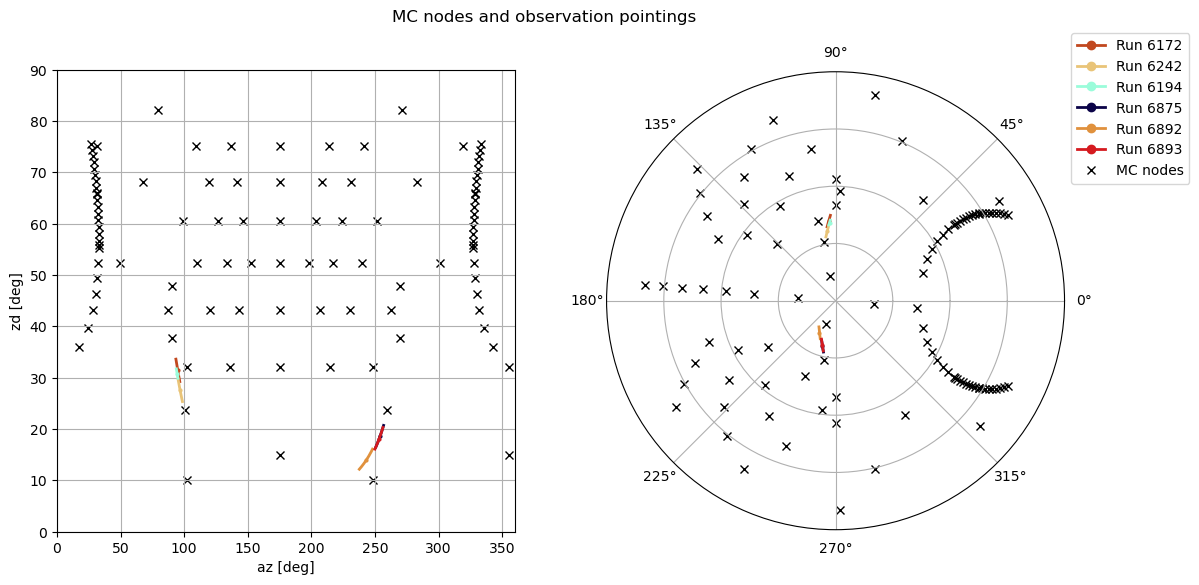

In [33]:
fig = plt.figure(figsize=(13, 6))
fig.suptitle("MC nodes and observation pointings")
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="polar")

colors = [np.random.rand(3) for _ in range(len(run_numbers))] # random color for each run
for method, ax in zip([np.array, np.deg2rad], [ax1, ax2]):
    for i, run in enumerate(run_numbers):
        
        ax.plot(method(DICT[run]["pointing"]["srunwise"]["az"]), DICT[run]["pointing"]["srunwise"]["zd"], marker="",  color=colors[i], ls="-", lw=2)
        ax.plot(method(DICT[run]["pointing"]["az"]),             DICT[run]["pointing"]["zd"],             marker="o", color=colors[i], ls="",  ms=2)
 
        ax.plot([], [], marker="o", ls="-", lw=2, color=colors[i], label=f"Run {run}")
    ax.plot(method(dict_nodes["pointing"]["az"]), dict_nodes["pointing"]["zd"], marker="x", ls="", color="k", zorder=-10, label="MC nodes")

for ax in [ax1, ax2]:
    ax.grid(True, zorder=-100)
    ax.set_ylim(0, 90)
ax1.set_xlim(0, 360)
ax2.legend(loc="upper left", bbox_to_anchor=(1, 1.1))
ax2.set_yticks([22.5, 45, 67.5], [])
ax1.set_xlabel("az [deg]")
ax1.set_ylabel("zd [deg]")
plt.show()

#### First the RFs we need to use for the source

#### Then the MC dl2 files associated to our observations

In [ ]:
# source_ra  = f"{source_coords.ra.deg}deg"
# source_dec = f"{source_coords.dec.deg}deg"